---
title: Aggregate temperature data to DHIS2 organisation units
short_title: Aggregata temperature data
---

In this notebook we will show how to load daily temperature data from NetCDF using [earthkit](https://ecmwf.github.io/earthkit-website/) and aggregate the data to DHIS2 organisation units. 

In [2]:
import earthkit.data
from earthkit.transforms import aggregate
from dhis2eo.integrations.pandas import df_to_dhis2_json

## Loading the data

Our sample NetCDF file contains daily temperature data for Sierra Leone in July 2025. Let's load the file using earthkit:

In [3]:
file = "../data/era5-land-daily-mean-temperature-2m-july-2025-sierra-leone.nc"
data = earthkit.data.from_source("file", file)

See [more examples](https://earthkit-data.readthedocs.io/en/latest/examples/) for how you can load data with eartkit, or see a [video of how to get data with earthkit](https://www.youtube.com/watch?v=no01ovW1pF8). 

[![How to get data with earthkit](https://img.youtube.com/vi/no01ovW1pF8/2.jpg)](https://www.youtube.com/watch?v=no01ovW1pF8)

To more easily work with and display the contents of the dataset we can convert it to an [xarray](https://xarray.dev). It shows that the file includes 3 dimensions (latitude, longitude and valid_time) and one data variable "t2m" (temperature at 2m above sea level). The data source is European Centre for Medium-Range Weather Forecasts ([ECMWF](https://www.ecmwf.int)). 

In [4]:
data_array = data.to_xarray()
data_array

<xarray.Dataset> Size: 209kB
Dimensions:     (valid_time: 31, latitude: 41, longitude: 41)
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 328B 10.0 9.9 9.8 9.7 9.6 ... 6.3 6.2 6.1 6.0
  * longitude   (longitude) float64 328B -14.0 -13.9 -13.8 ... -10.2 -10.1 -10.0
  * valid_time  (valid_time) datetime64[ns] 248B 2025-07-01 ... 2025-07-31
Data variables:
    t2m         (valid_time, latitude, longitude) float32 208kB dask.array<chunksize=(31, 41, 41), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-08-07T14:32 GRIB to CDM+CF via cfgrib-0.9.1...

We can also visualize the data to see what it looks like on a map for one of the dates:

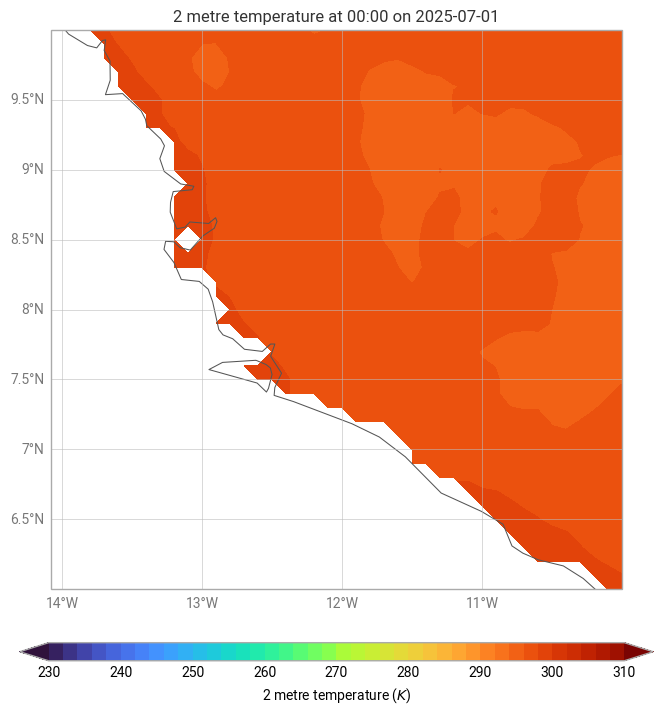

In [14]:
data_array_on_date = data_array.sel(valid_time='2025-07-01')
fig = earthkit.plots.quickplot(data_array_on_date)

## Loading the organisation units

Eartkit can also be used to load the organisation units from DHIS2 that we [saved as a GeoJSON file](organization-units). 

In [6]:
district_file = "../data/sierra-leone-districts.geojson"
features = earthkit.data.from_source("file", district_file)

We can convert this to `geopandas` to more easily see the information we have for each org unit. For the aggregation, we are particularly interested in the id and the geometry (polygon) of the org unit. 

In [7]:
features_gpd = features.to_geopandas()
features_gpd

,type,id,name,hasCoordinatesDown,hasCoordinatesUp,level,grandParentParentGraph,grandParentId,parentGraph,parentId,parentName,dimensions,weight,geometry
0,Polygon,O6uvpzGd5pu,Bo,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"POLYGON ((-11.5914 8.4875, -11.5906 8.4769, -1..."
1,Polygon,fdc6uOvgoji,Bombali,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"POLYGON ((-11.8091 9.2032, -11.8102 9.1944, -1..."
2,MultiPolygon,lc3eMKXaEfw,Bonthe,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"MULTIPOLYGON (((-12.5568 7.3832, -12.5574 7.38..."
3,Polygon,jUb8gELQApl,Kailahun,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"POLYGON ((-10.7972 7.5866, -10.8002 7.5878, -1..."
4,MultiPolygon,PMa2VCrupOd,Kambia,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"MULTIPOLYGON (((-13.1349 8.8471, -13.1343 8.84..."
5,Polygon,kJq2mPyFEHo,Kenema,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"POLYGON ((-11.3596 8.5317, -11.3513 8.5234, -1..."
6,Polygon,qhqAxPSTUXp,Koinadugu,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"POLYGON ((-10.585 9.0434, -10.5877 9.0432, -10..."
7,Polygon,Vth0fbpFcsO,Kono,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"POLYGON ((-10.585 9.0434, -10.5848 9.0432, -10..."
8,MultiPolygon,jmIPBj66vD6,Moyamba,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"MULTIPOLYGON (((-12.6351 7.6613, -12.6346 7.66..."
9,MultiPolygon,TEQlaapDQoK,Port Loko,True,False,2,,,ImspTQPwCqd,ImspTQPwCqd,Sierra Leone,{ },1,"MULTIPOLYGON (((-13.119 8.4718, -13.1174 8.470..."


Next, since our goal is to aggregate temperature data to the organisation units, let's add the organisation units to the map figure we made earlier to see how they compare: 

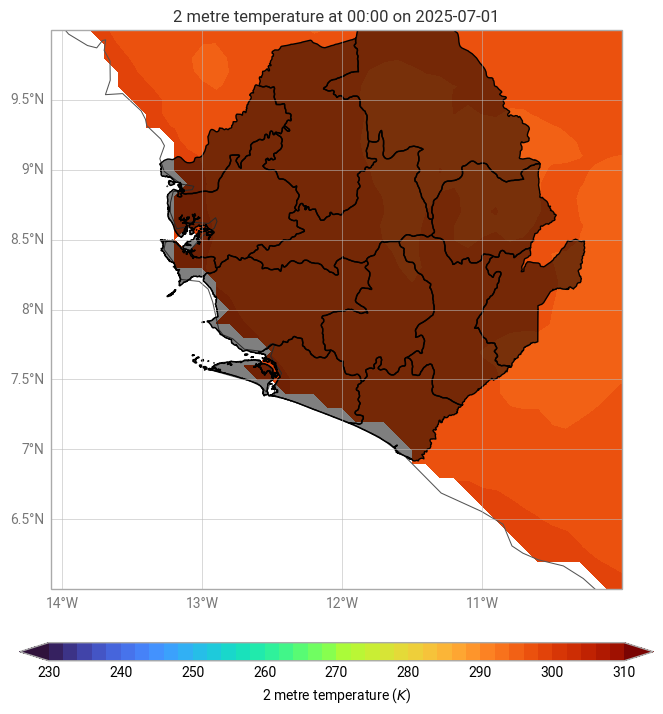

In [15]:
from IPython.display import display
m = fig.subplots[0]
m.ax.add_geometries(
    features_gpd.geometry, # selects only the geometry column for visualization
    crs=m.crs, 
    facecolor=(0, 0, 0, 0.5), 
    edgecolor="black" 
)
display(fig.fig)

## Aggregating the data to organisation units

To aggregate the data to the org unit features we use the aggregate package of [earthkit-transforms](https://earthkit-transforms.readthedocs.io). We keep the daily period type and only aggregate the data spatially to the org unit features. The parameter `mask_dim` is the dimension (org unit id) that will be created after the reduction of the spatial dimensions (longitude/latitude grid). 

In [ ]:
agg_data = aggregate.spatial.reduce(data, features, mask_dim="id")
agg_data

<xarray.Dataset> Size: 2kB
Dimensions:     (valid_time: 31, id: 13)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 248B 2025-07-01 ... 2025-07-31
  * id          (id) object 104B 'O6uvpzGd5pu' 'fdc6uOvgoji' ... 'at6UHUQatSo'
Data variables:
    t2m         (id, valid_time) float32 2kB 296.8 297.3 297.3 ... 298.6 298.1
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-08-07T14:32 GRIB to CDM+CF via cfgrib-0.9.1...

We see that the aggregated data is returned as an `xarray` with two dimensions (`id` representing the org unit id and `valid_time` as the time period), and the same temperature variable.

To more easily work with tabular aggregated data, we convert the results to a `pandas.DataFrame` and inspect the results:

In [ ]:
agg_df = agg_data.to_dataframe().reset_index()
agg_df

,valid_time,id,number,t2m
0,2025-07-01,O6uvpzGd5pu,0,296.833954
1,2025-07-01,fdc6uOvgoji,0,297.109039
2,2025-07-01,lc3eMKXaEfw,0,297.670990
3,2025-07-01,jUb8gELQApl,0,296.213776
4,2025-07-01,PMa2VCrupOd,0,297.604492
...,...,...,...,...
398,2025-07-31,jmIPBj66vD6,0,297.406494
399,2025-07-31,TEQlaapDQoK,0,297.758301
400,2025-07-31,bL4ooGhyHRQ,0,296.777893
401,2025-07-31,eIQbndfxQMb,0,296.707397


## Post-processing

Next, we convert temperatures in kelvin to celcius by subtracting 273.15 from the values.

In [ ]:
agg_df['t2m'] -= 273.15
agg_df

,valid_time,id,number,t2m
0,2025-07-01,O6uvpzGd5pu,0,23.683960
1,2025-07-01,fdc6uOvgoji,0,23.959045
2,2025-07-01,lc3eMKXaEfw,0,24.520996
3,2025-07-01,jUb8gELQApl,0,23.063782
4,2025-07-01,PMa2VCrupOd,0,24.454498
...,...,...,...,...
398,2025-07-31,jmIPBj66vD6,0,24.256500
399,2025-07-31,TEQlaapDQoK,0,24.608307
400,2025-07-31,bL4ooGhyHRQ,0,23.627899
401,2025-07-31,eIQbndfxQMb,0,23.557404


Two decimals is sufficient for our use so we round all the temperature values:  

In [ ]:
agg_df['t2m'] = agg_df['t2m'].astype('float64').round(decimals=2)
agg_df

,valid_time,id,number,t2m
0,2025-07-01,O6uvpzGd5pu,0,23.68
1,2025-07-01,fdc6uOvgoji,0,23.96
2,2025-07-01,lc3eMKXaEfw,0,24.52
3,2025-07-01,jUb8gELQApl,0,23.06
4,2025-07-01,PMa2VCrupOd,0,24.45
...,...,...,...,...
398,2025-07-31,jmIPBj66vD6,0,24.26
399,2025-07-31,TEQlaapDQoK,0,24.61
400,2025-07-31,bL4ooGhyHRQ,0,23.63
401,2025-07-31,eIQbndfxQMb,0,23.56


## Converting to DHIS2 Format

Use the `dhsi2eo` utility function `df_to_dhis2_json` to translate the `pandas` DataFrame into the JSON structure used by the DHIS2 Web API:

In [ ]:
json_dict = df_to_dhis2_json(
    df = agg_df,                    # aggregated pandas.DataFrame
    org_unit_col = 'id',            # column containing the org unit id
    period_col = 'valid_time',      # column containing the period
    value_col = 't2m',              # column containing the value
    data_element_id = 'VJwwPOOvge6' # id of the DHIS2 data element
)

C:\Users\karimba\Documents\Github\climate-tools\dhis2eo\integrations\pandas.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.rename(columns=remap, inplace=True)
C:\Users\karimba\Documents\Github\climate-tools\dhis2eo\integrations\pandas.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['period'] = df_subset['period'].apply(parse_period)


We can display the first 3 items to see that we have one temperature value for each org unit and period combination.

In [ ]:
json_dict['dataValues'][:3]

[{'orgUnit': 'O6uvpzGd5pu',
  'period': '20250701',
  'value': 23.68,
  'dataElement': 'VJwwPOOvge6'},
 {'orgUnit': 'fdc6uOvgoji',
  'period': '20250701',
  'value': 23.96,
  'dataElement': 'VJwwPOOvge6'},
 {'orgUnit': 'lc3eMKXaEfw',
  'period': '20250701',
  'value': 24.52,
  'dataElement': 'VJwwPOOvge6'}]